# test6 otsu 2 classes white background

In [7]:
import keras
from keras import layers
from keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

# Creating Dataset

In [8]:
CLASSES = [
    'фон',
    'яблоко',
    'цветок'
]

colormap = [
    [0, 0, 0],
    [212, 6, 99],
    [121, 133, 255]
]


IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = len(CLASSES)
DATA_DIR = "C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white"
NUM_TRAIN_IMAGES = 2334
NUM_VAL_IMAGES = 666
NUM_TEST_IMAGES = 333

train_images = sorted(glob(os.path.join(DATA_DIR, "original/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "mask/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "original/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "mask/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
test_images = sorted(glob(os.path.join(DATA_DIR, "original/*")))[NUM_VAL_IMAGES + NUM_TRAIN_IMAGES : NUM_TEST_IMAGES + NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
test_masks = sorted(glob(os.path.join(DATA_DIR, "mask/*")))[NUM_VAL_IMAGES + NUM_TRAIN_IMAGES : NUM_TEST_IMAGES + NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]


def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


# Building the DeepLabV3+ model

In [9]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [10]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 512, 512, 3)       │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item (GetItem)            │ (None, 512, 512)          │           0 │ input_layer[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 512, 512)          │           0 │ input_layer[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 512, 512)          │           0 │ input_layer[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ stack (Stack)                 │ (None, 512, 512, 3)       │           0 │ get_item[0][0],                │
│                               │                           │             │ get_item_1[0][0],              │
│                               │                           │             │ get_item_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ add (Add)                     │ (None, 512, 512, 3)       │           0 │ stack[0][0]                    │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 518, 518, 3)       │           0 │ add[0][0]                      │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 256, 256, 64)      │       9,472 │ conv1_pad[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 256, 256, 64)      │         256 │ conv1_conv[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 256, 256, 64)      │           0 │ conv1_bn[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 258, 258, 64)      │           0 │ conv1_relu[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 128, 128, 64)      │           0 │ pool1_pad[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 128, 128, 64)      │       4,160 │ pool1_pool[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 128, 128, 64)      │         256 │ conv2_block1_1_conv[0][0]      │
│ (BatchNormalization)          │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 128, 128, 64)      │           0 │ conv2_block1_1_bn[0][0]        │
│ (Activation)                  │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 11,852,867 (45.22 MB)

 Trainable params: 11,820,131 (45.09 MB)

 Non-trainable params: 32,736 (127.88 KB)

# Training

Epoch 1/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 7198s 12s/step - accuracy: 0.9484 - loss: 0.1423 - val_accuracy: 0.9725 - val_loss: 0.0814
Epoch 2/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 7064s 12s/step - accuracy: 0.9856 - loss: 0.0388 - val_accuracy: 0.4389 - val_loss: 0.9428
Epoch 3/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 7088s 12s/step - accuracy: 0.9907 - loss: 0.0250 - val_accuracy: 0.9949 - val_loss: 0.0158
Epoch 4/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 7084s 12s/step - accuracy: 0.9947 - loss: 0.0140 - val_accuracy: 0.9955 - val_loss: 0.0122
Epoch 5/5
583/583 ━━━━━━━━━━━━━━━━━━━━ 7086s 12s/step - accuracy: 0.9951 - loss: 0.0127 - val_accuracy: 0.9949 - val_loss: 0.0133


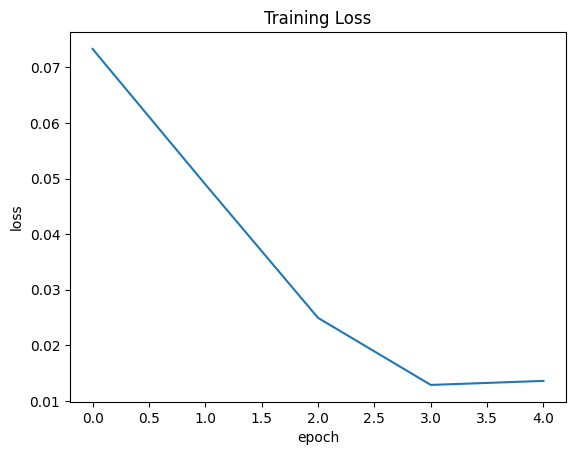

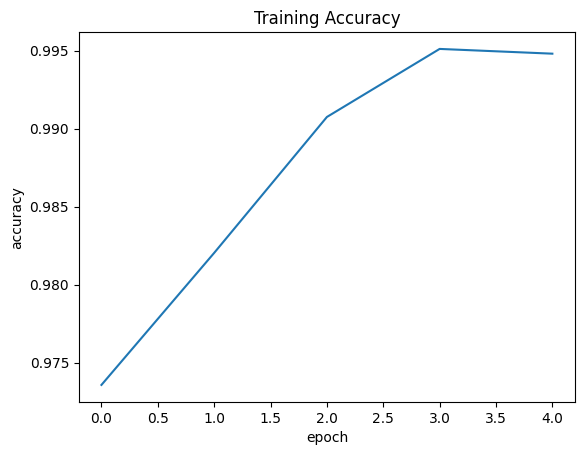

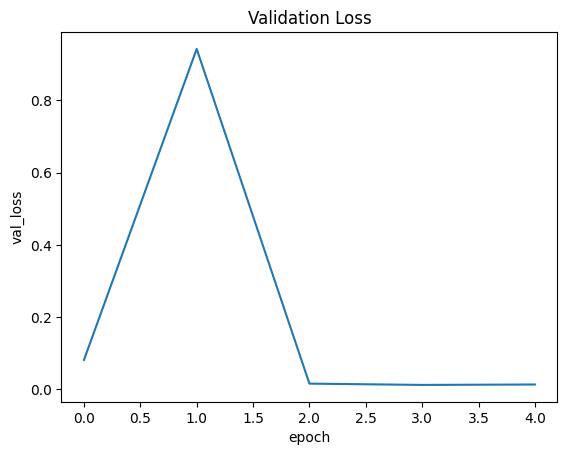

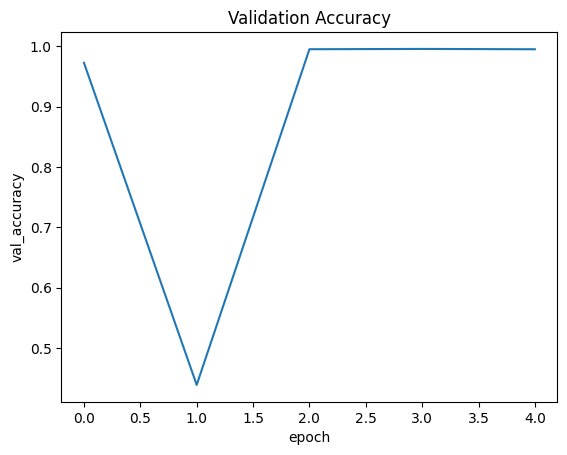

In [11]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

## Inference using Colormap Overlay



In [12]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)

    # print(mask[250])

    
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l][0]
        g[idx] = colormap[l][1]
        b[idx] = colormap[l][2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def _predictions(images_list, colormap, mod, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, len(CLASSES))

        name = image_file.split("\\")[2]
        if mod == "train":
            if not (os.path.exists("C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/train_pred")):
                os.makedirs("C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/train_pred")
            path = f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/train_pred/{name}"
        elif  mod == "val":
            if not (os.path.exists("C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/val_pred")):
                os.makedirs("C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/val_pred")
            path = f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/val_pred/{name}"
        else: 
            if not (os.path.exists("C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/test_pred")):
                os.makedirs("C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/test_pred")
            path = f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/test_pred/{name}"
        pred_map = cv2.cvtColor(prediction_colormap, cv2.COLOR_BGR2RGB)
        cv2.imwrite(path, pred_map)
            

def plot_predictions(images_list, colormap, mod, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, len(CLASSES))

        # name = image_file.split("\\")[2]
        # if mod == "train":
        #     path = f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/train_pred/{name}"
        # elif  mod == "val":
        #     path = f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/val_pred/{name}"
        # else: 
        #     path = f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/test_pred/{name}"
        # pred_map = cv2.cvtColor(prediction_colormap, cv2.COLOR_BGR2RGB)
        # cv2.imwrite(path, pred_map)
            
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

### Inference on Train Images

In [13]:
_predictions(train_images, colormap, "train", model=model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


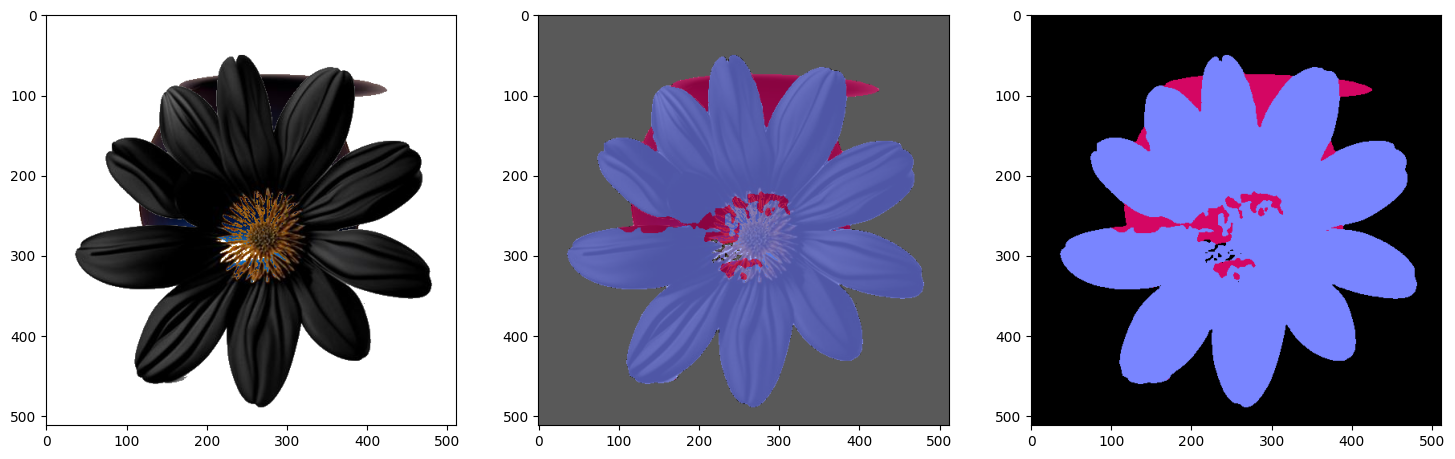

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


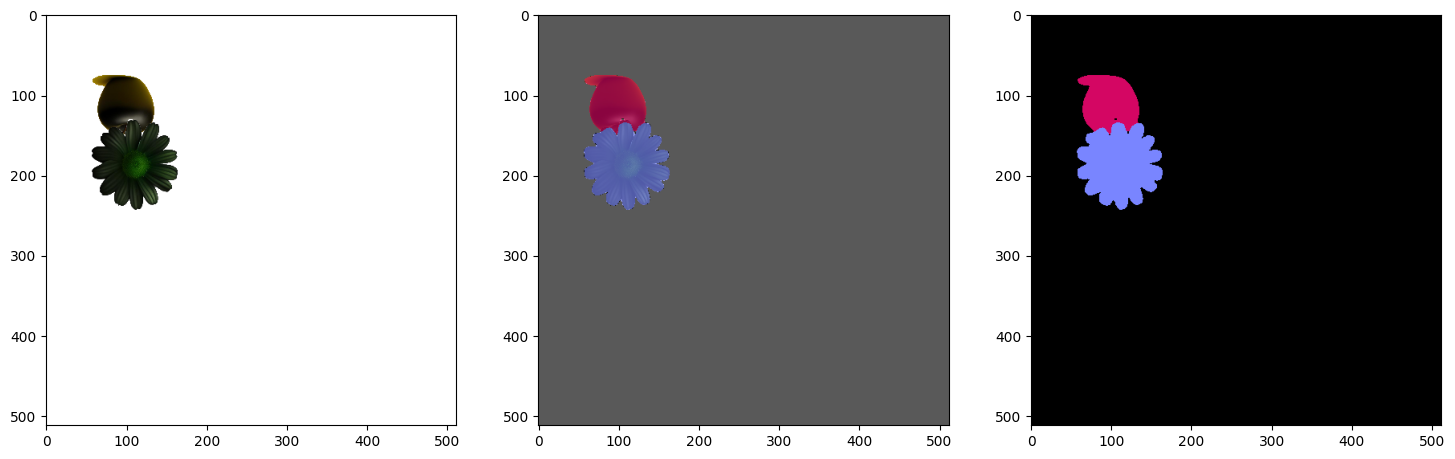

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


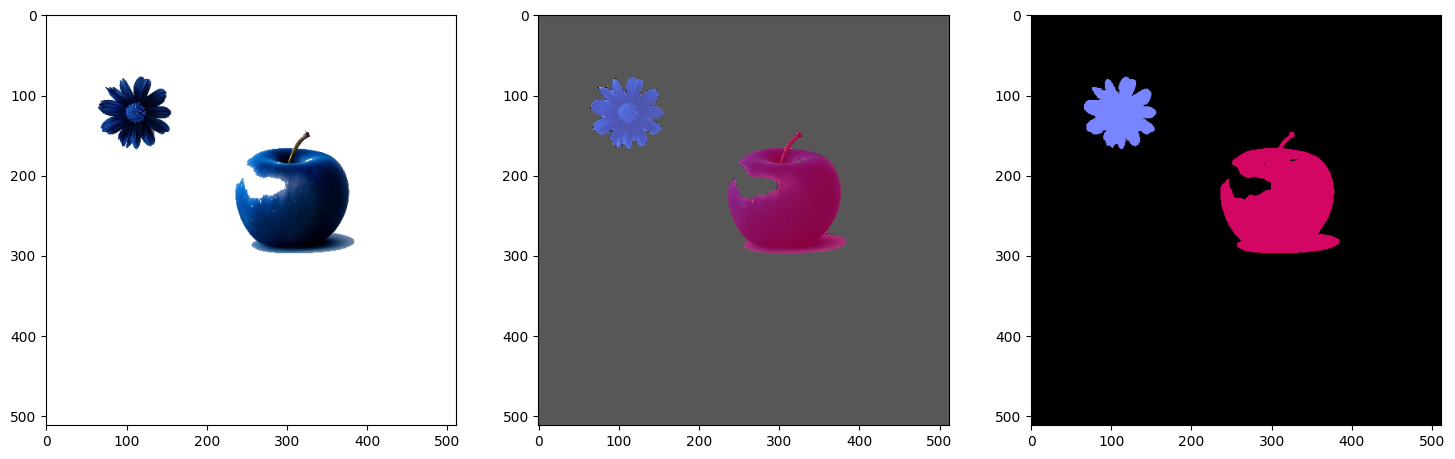

In [14]:
plot_predictions(train_images[:3], colormap, "train", model=model)

### Inference on Validation Images

In [15]:
_predictions(val_images, colormap, "val", model=model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


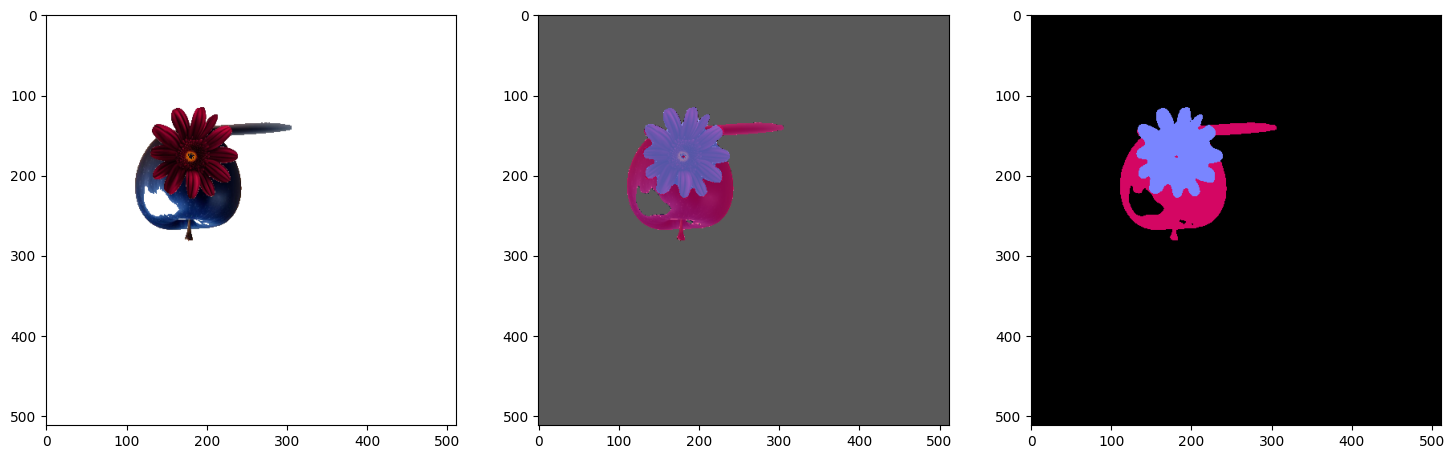

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


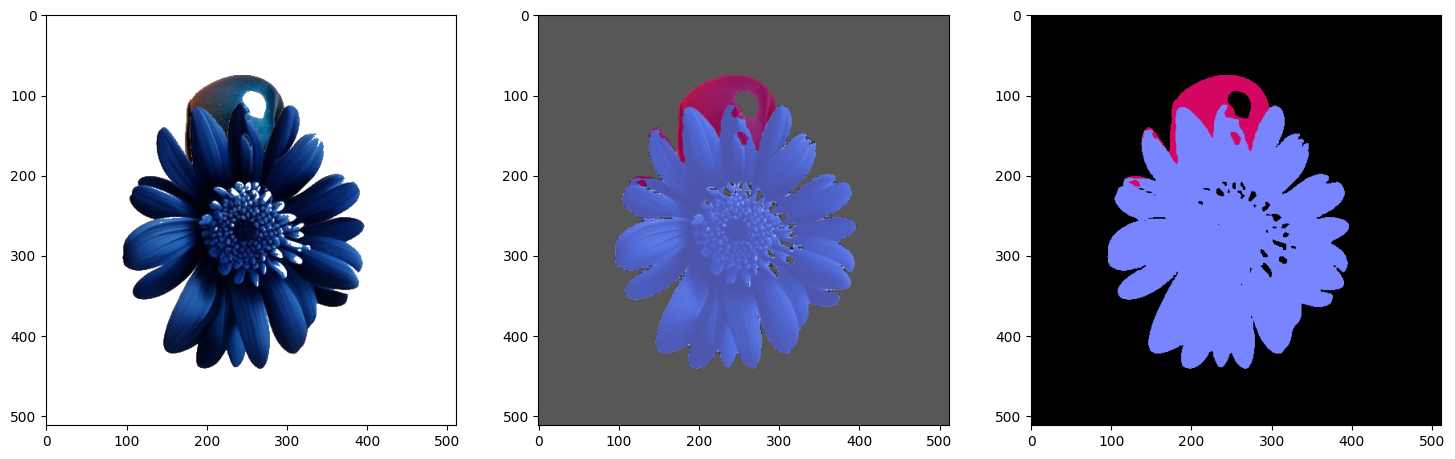

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


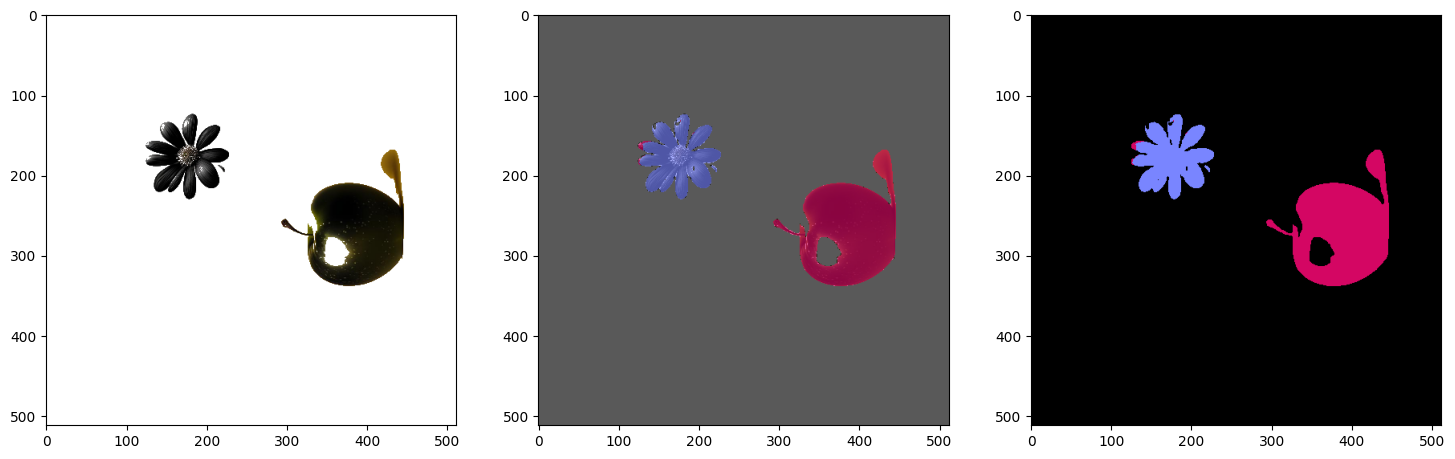

In [16]:
plot_predictions(val_images[:3], colormap, "val", model=model)

## Inference on Testing Images

In [17]:
_predictions(test_images, colormap, "test", model=model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


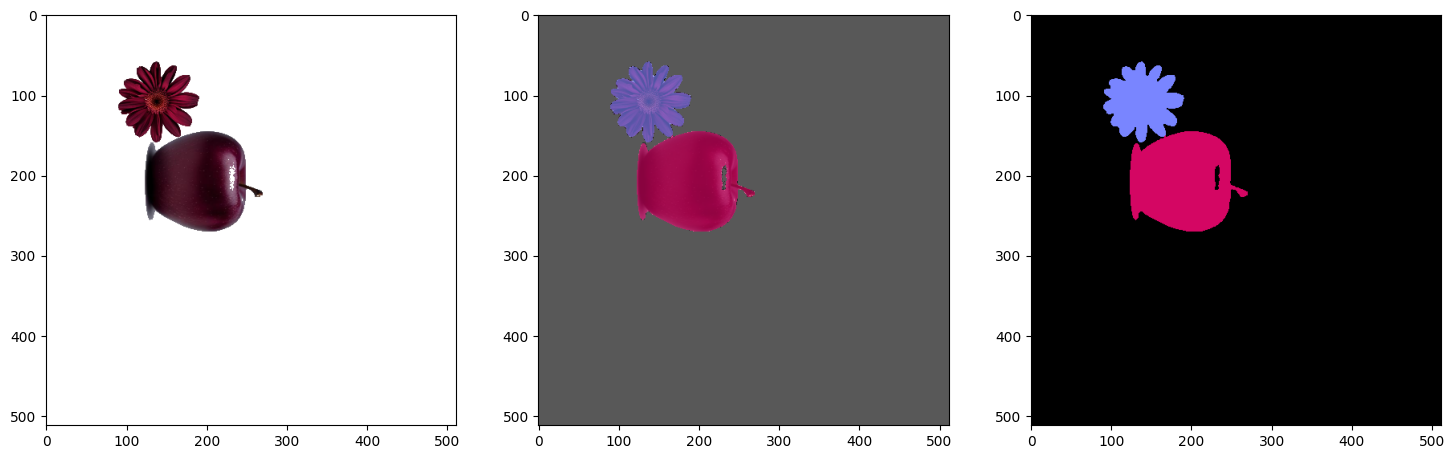

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


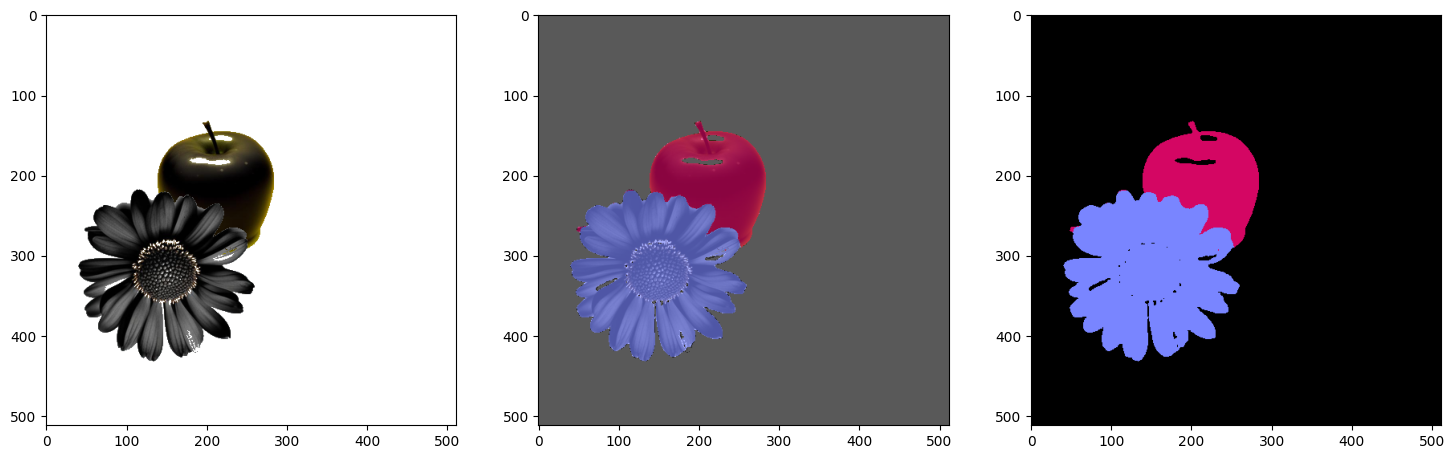

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


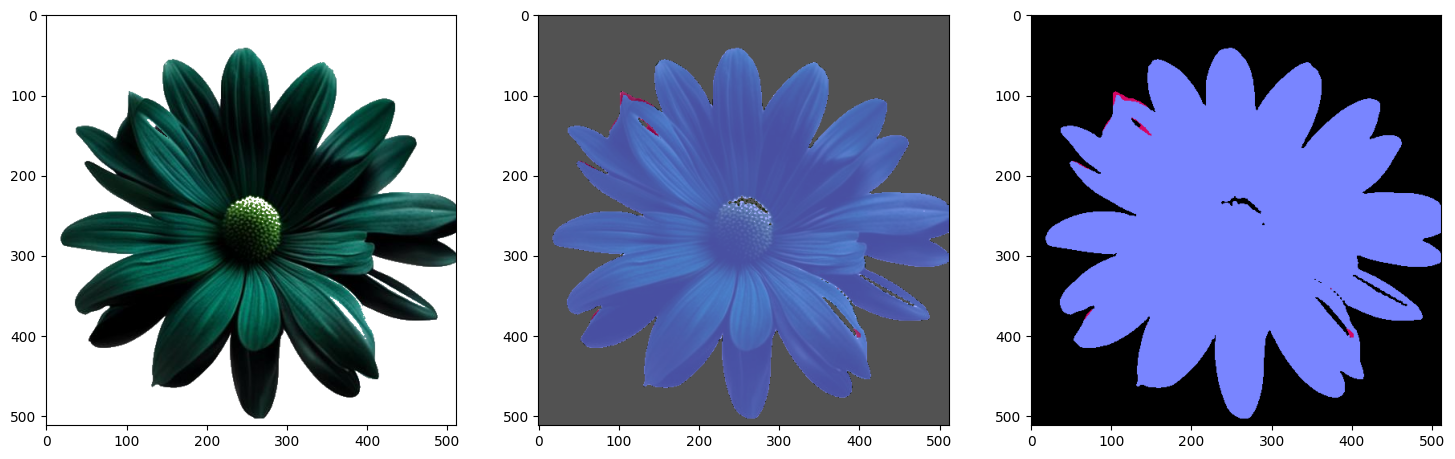

In [18]:
plot_predictions(test_images[:3], colormap, "test", model=model)

In [27]:
for i in range(3333):
    img = cv2.imread(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/mask/image{i}.png")
    for k in range(img.shape[0]):
        for m in range(img.shape[0]):
            if list(img[k,m]) == [1,1,1]: img[k,m] = [99, 6, 212]
            elif list(img[k,m]) == [2,2,2]: img[k,m] = [255, 133, 121]
    cv2.imwrite(f"C:/Users/iraor/PycharmProjects/FusionBrainGen/join_classes_otsu_white/mask_color/image{i}.png", img)

# IOU for train

In [31]:
train_pred = sorted(glob(os.path.join(DATA_DIR, "train_pred/*")))
mask_color = sorted(glob(os.path.join(DATA_DIR, "mask_color/*")))[:NUM_TRAIN_IMAGES]

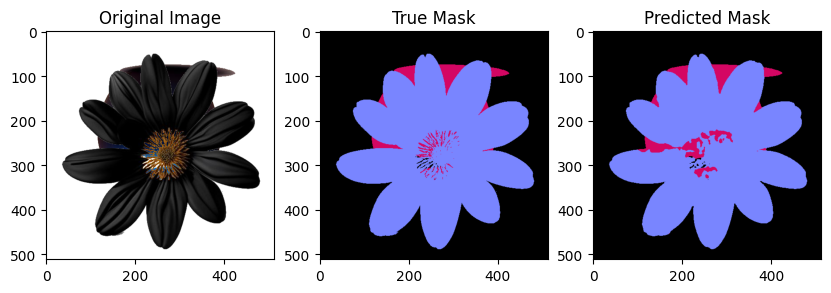

image0 IOU_apple: 0.589520624303233
image0 IOU_flower: 0.9642973863425578
image0 IOU_back: 0.9969314931548694


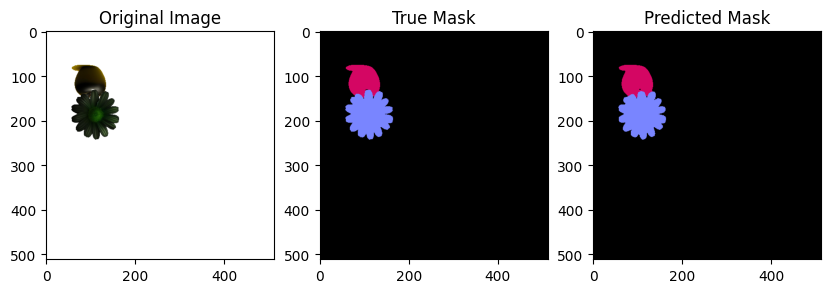

image1 IOU_apple: 0.9722830051057623
image1 IOU_flower: 0.9764407393983328
image1 IOU_back: 0.9995239390642002


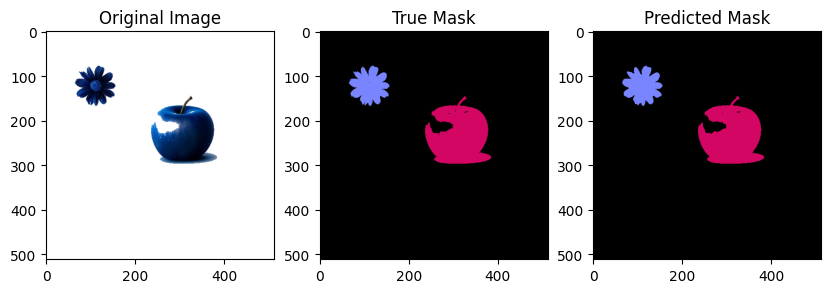

image2 IOU_apple: 0.9905660377358491
image2 IOU_flower: 0.9741704374057315
image2 IOU_back: 0.9988613015818006


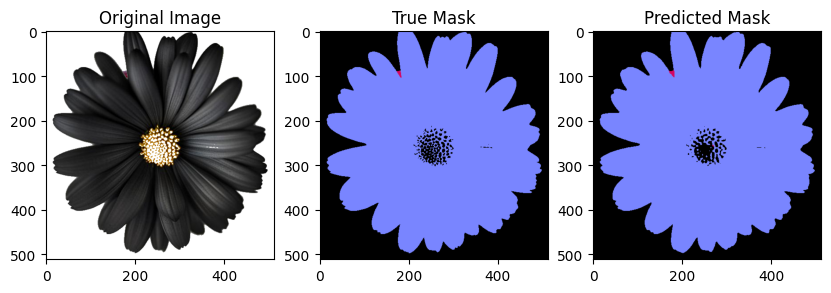

image3 IOU_apple: 0.6541353383458647
image3 IOU_flower: 0.9892516384697455
image3 IOU_back: 0.9826874110311365


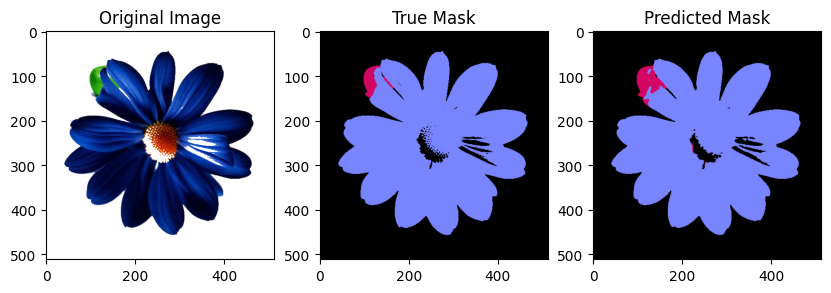

image4 IOU_apple: 0.5630397236614854
image4 IOU_flower: 0.9793322883718311
image4 IOU_back: 0.9932564112492095


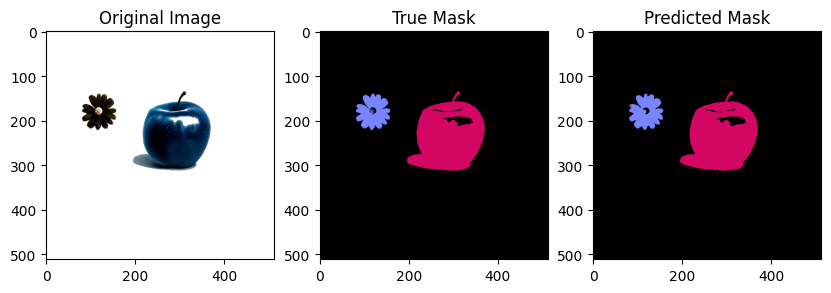

image5 IOU_apple: 0.9886524107322978
image5 IOU_flower: 0.9561464893865174
image5 IOU_back: 0.9984271651644346


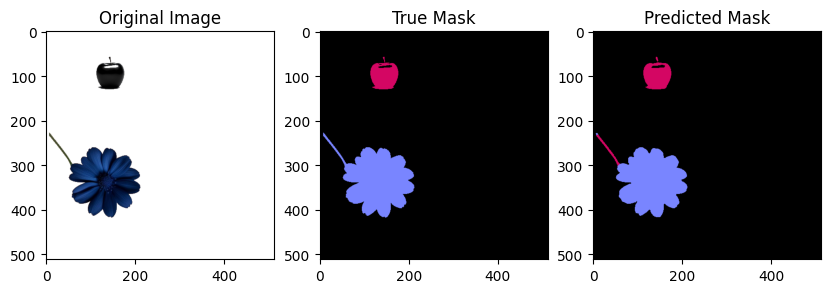

image6 IOU_apple: 0.8625565610859729
image6 IOU_flower: 0.9700629358734478
image6 IOU_back: 0.998981792293906


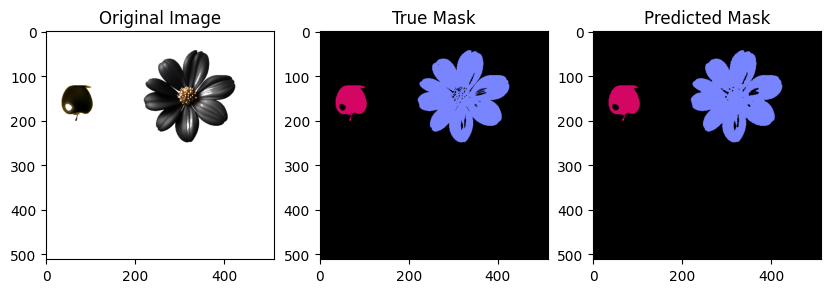

image7 IOU_apple: 0.9876315789473684
image7 IOU_flower: 0.9758906938872781
image7 IOU_back: 0.997202988610946


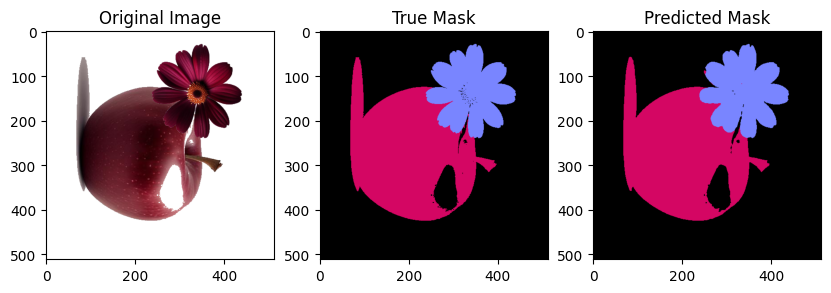

image8 IOU_apple: 0.9890743358053707
image8 IOU_flower: 0.9786782850092536
image8 IOU_back: 0.9965261828203951


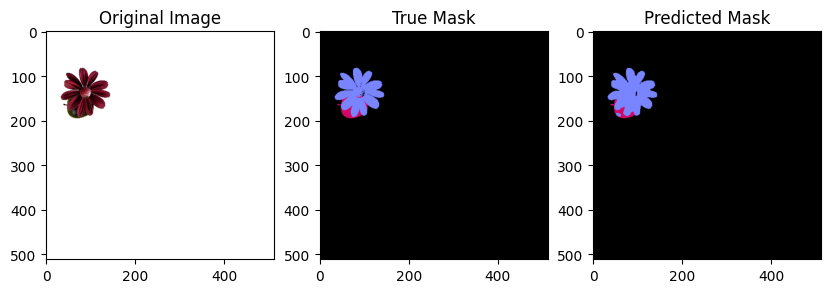

image9 IOU_apple: 0.6229729729729729
image9 IOU_flower: 0.9417385534173855
image9 IOU_back: 0.9992450574857269


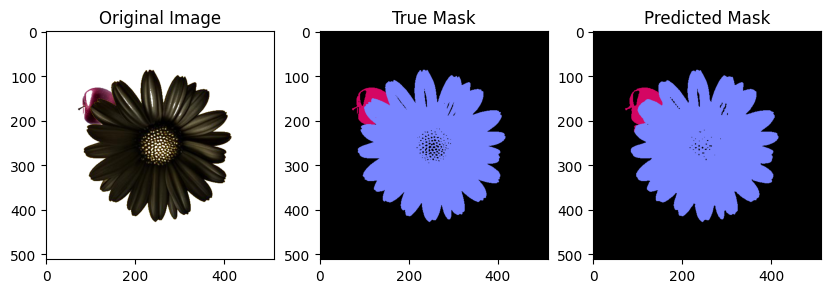

image10 IOU_apple: 0.8890915724188252
image10 IOU_flower: 0.9830459123575579
image10 IOU_back: 0.9936025827210349


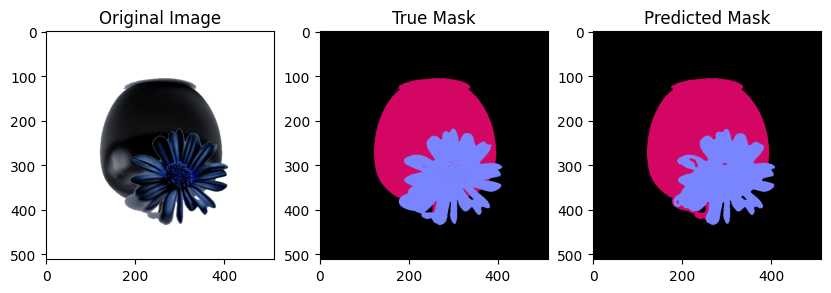

image11 IOU_apple: 0.9623691020339065
image11 IOU_flower: 0.9475790578664217
image11 IOU_back: 0.9988333333333334


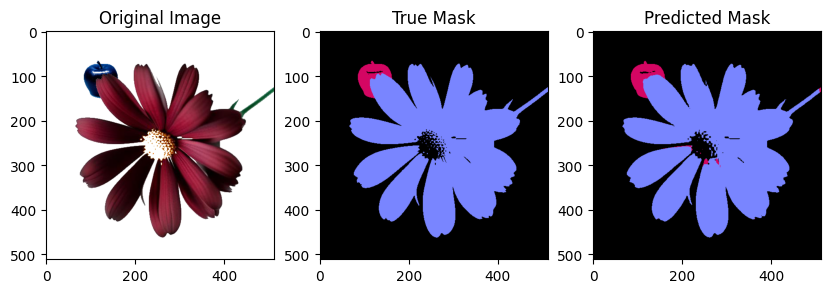

image12 IOU_apple: 0.8475054910574208
image12 IOU_flower: 0.9836405713829702
image12 IOU_back: 0.9934651115677365


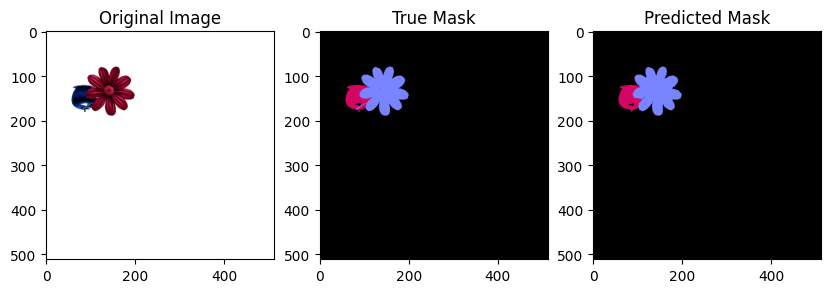

image13 IOU_apple: 0.924220623501199
image13 IOU_flower: 0.9746316463805254
image13 IOU_back: 0.9995009802174301


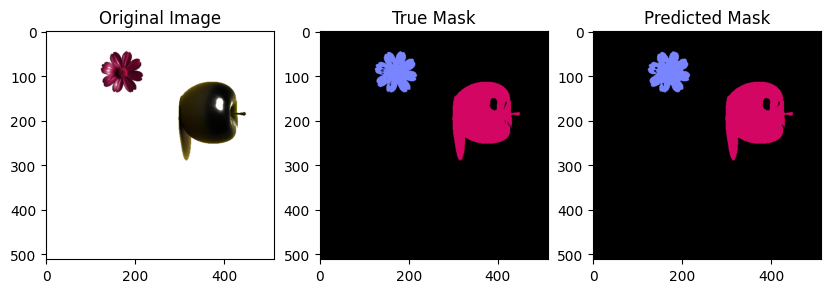

image14 IOU_apple: 0.9944621681815445
image14 IOU_flower: 0.9720930232558139
image14 IOU_back: 0.9989156319988656


KeyboardInterrupt: 

In [30]:
IOU_sum_apple = 0
IOU_sum_flower = 0
IOU_sum_back = 0

def claculate_IOU(true_mask, pred_mask, color):
    intersection = 0
    union = 0
    sum = 0
    
    for k in range(true_mask.shape[0]):
        for l in range(true_mask.shape[1]):
            if (list(true_mask[k, l]) == color) and (list(true_mask[k, l]) == list(pred_mask[k, l])): 
                intersection+=1
            if list(true_mask[k, l]) == color:
                sum+=1
            if list(pred_mask[k, l]) == color:
                sum+=1
            union = sum - intersection

    if intersection == 0: IOU = 1
    else: IOU = intersection/union
    return IOU

    
for i in range(NUM_TRAIN_IMAGES):
    img = cv2.imread(train_images[i])
    true_mask = cv2.imread(mask_color[i])
    pred_mask = cv2.imread(train_pred[i])

    IOU_apple = claculate_IOU(true_mask, pred_mask, [99, 6, 212])
    IOU_flower = claculate_IOU(true_mask, pred_mask, [255, 133, 121])
    IOU_back = claculate_IOU(true_mask, pred_mask, [0, 0, 0])
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    true_mask = cv2.cvtColor(true_mask, cv2.COLOR_BGR2RGB)
    pred_mask = cv2.cvtColor(pred_mask, cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(img)
    axs[0].set_title('Original Image')
    axs[1].imshow(true_mask)
    axs[1].set_title('True Mask')
    axs[2].imshow(pred_mask)
    axs[2].set_title('Predicted Mask')
    plt.show()
    
    print(f"image{i} IOU_apple: {IOU_apple}")
    print(f"image{i} IOU_flower: {IOU_flower}")
    print(f"image{i} IOU_back: {IOU_back}")
    
    IOU_sum_apple += IOU_apple
    IOU_sum_flower += IOU_flower
    IOU_sum_back += IOU_back

MIOU_apple_train = IOU_sum_apple / NUM_TEST_IMAGES
MIOU_flower_train = IOU_sum_flower / NUM_TEST_IMAGES
MIOU_back_train = IOU_sum_back / NUM_TEST_IMAGES
print(f"\n MIOU_apple: {MIOU_apple_train}")
print(f"\n MIOU_flower: {MIOU_flower_train}")
print(f"\n MIOU_back: {MIOU_back_train}")
print(f"\n MIOU for all classes: {(MIOU_apple_train+MIOU_flower_train+MIOU_back_train)/3}")